In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import seaborn as sns

In [2]:
site_1 = pd.read_pickle("utilization_data_site1.pkl")
site_2 = pd.read_pickle("utilization_data_site2.pkl")

In [3]:
site_1

,hour,weekday,month,holiday,utilization,temperature,precipitation
0,13,0,10,True,0.076923,13.0,0.0
1,14,0,10,True,0.365385,14.0,0.0
2,15,0,10,True,0.365385,17.0,0.0
3,16,0,10,True,0.365385,18.0,0.0
4,17,0,10,True,0.365385,20.0,0.0
...,...,...,...,...,...,...,...
12966,19,1,3,True,0.057692,23.0,0.0
12967,20,1,3,True,0.057692,24.0,0.0
12968,21,1,3,True,0.057692,25.0,0.0
12969,22,1,3,True,0.057692,24.0,0.0


In [4]:
site_1_X = site_1.drop(columns = "utilization")
site_1_y = site_1['utilization']
site_2_X = site_2.drop(columns = 'utilization')
site_2_y = site_2['utilization']

In [5]:
# Split data into train, test, validation 60/20/20
site_1_X_train, site_1_X_test, site_1_y_train, site_1_y_test = train_test_split(site_1_X, site_1_y, test_size= 0.4, random_state=42)
site_2_X_train, site_2_X_test, site_2_y_train, site_2_y_test = train_test_split(site_2_X, site_2_y, test_size= 0.4, random_state=42)

site_1_X_test, site_1_X_val, site_1_y_test, site_1_y_val = train_test_split(site_1_X_test, site_1_y_test, test_size=0.5, random_state=42)
site_2_X_test, site_2_X_val, site_2_y_test, site_2_y_val = train_test_split(site_2_X_test, site_2_y_test, test_size=0.5, random_state=42)

In [6]:
# Scale data using MinMaxScaler from sklearn
site_1_scaler = MinMaxScaler()
site_2_scaler = MinMaxScaler()

site_1_scaler.fit(site_1_X_train)
site_2_scaler.fit(site_2_X_train)

site_1_X_train = site_1_scaler.fit_transform(site_1_X_train)
site_1_X_test  = site_1_scaler.transform(site_1_X_test)
site_1_X_val  = site_1_scaler.transform(site_1_X_val)


site_2_X_train = site_2_scaler.fit_transform(site_2_X_train)
site_2_X_test  = site_2_scaler.transform(site_2_X_test)
site_2_X_val  = site_2_scaler.transform(site_2_X_val)

In [7]:
tf.random.set_seed(42)
# Build a relatively simple neural net with a few layers
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_1.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_1 = model_1.fit(site_1_X_train,
                    site_1_y_train,
                    validation_data = (site_1_X_val,site_1_y_val),
                    epochs = 100)



Epoch 1/100


244/244 [==============================] - 1s 1ms/step - loss: 0.0838 - mae: 0.2011 - val_loss: 0.0481 - val_mae: 0.1469
Epoch 2/100
244/244 [==============================] - 0s 873us/step - loss: 0.0449 - mae: 0.1414 - val_loss: 0.0378 - val_mae: 0.1285
Epoch 3/100
244/244 [==============================] - 0s 877us/step - loss: 0.0362 - mae: 0.1216 - val_loss: 0.0301 - val_mae: 0.1086
Epoch 4/100
244/244 [==============================] - 0s 856us/step - loss: 0.0304 - mae: 0.1086 - val_loss: 0.0265 - val_mae: 0.1011
Epoch 5/100
244/244 [==============================] - 0s 873us/step - loss: 0.0268 - mae: 0.1008 - val_loss: 0.0288 - val_mae: 0.1193
Epoch 6/100
244/244 [==============================] - 0s 867us/step - loss: 0.0247 - mae: 0.0972 - val_loss: 0.0246 - val_mae: 0.1096
Epoch 7/100
244/244 [==============================] - 0s 861us/step - loss: 0.0229 - mae: 0.0909 - val_loss: 0.0224 - val_mae: 0.0849
Epoch 8/100
244/244 [==============================] 

<Axes: >

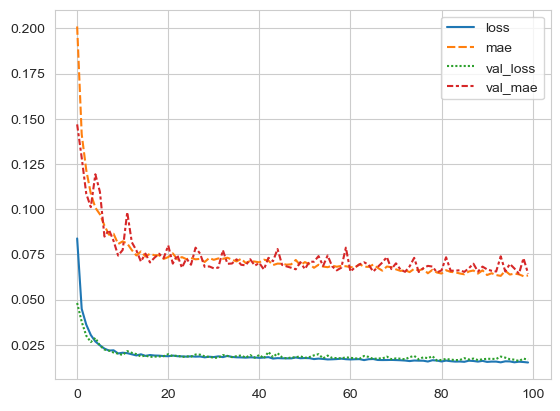

In [8]:
sns.lineplot(history_model_1.history)

While the decrease of loss levels out relatively quick after about 10 epochs, there is still a slight downward trend recognizable. Because the model complexity and the amount of data is rather low, epochs don't take very long to run. We will use an early stopping callback to let the training run for a high amount of epochs, until there is a divergence between training and validation loss, which would indicate overfitting.

In [11]:
# Early stopping callback that monitors validation loss and stops training after it stops decreasing for more than 10 epochs. Restores the model to the best weights it achieved on val loss afterwards.
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 25, restore_best_weights = True)

# Build a relatively simple neural net with a few layers
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_2.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_2 = model_2.fit(site_1_X_train,
                    site_1_y_train,
                    validation_data = (site_1_X_val,site_1_y_val),
                    epochs = 10000,
                    callbacks = [early_stop])

Epoch 1/10000
244/244 [==============================] - 1s 1ms/step - loss: 0.0684 - mae: 0.1873 - val_loss: 0.0463 - val_mae: 0.1490
Epoch 2/10000
244/244 [==============================] - 0s 872us/step - loss: 0.0419 - mae: 0.1352 - val_loss: 0.0349 - val_mae: 0.1242
Epoch 3/10000
244/244 [==============================] - 0s 857us/step - loss: 0.0325 - mae: 0.1127 - val_loss: 0.0269 - val_mae: 0.1003
Epoch 4/10000
244/244 [==============================] - 0s 855us/step - loss: 0.0250 - mae: 0.0937 - val_loss: 0.0222 - val_mae: 0.0833
Epoch 5/10000
244/244 [==============================] - 0s 852us/step - loss: 0.0226 - mae: 0.0854 - val_loss: 0.0224 - val_mae: 0.0815
Epoch 6/10000
244/244 [==============================] - 0s 856us/step - loss: 0.0221 - mae: 0.0827 - val_loss: 0.0209 - val_mae: 0.0793
Epoch 7/10000
244/244 [==============================] - 0s 852us/step - loss: 0.0213 - mae: 0.0801 - val_loss: 0.0223 - val_mae: 0.0890
Epoch 8/10000
244/244 [====================

<Axes: >

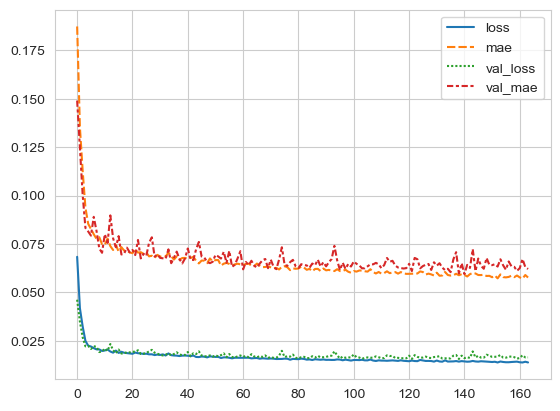

In [12]:
sns.lineplot(history_model_2.history)

In [19]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 25, restore_best_weights = True)

# Build a relatively simple neural net with a few layers
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_3.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_3 = model_3.fit(site_1_X_train,
                    site_1_y_train,
                    validation_data = (site_1_X_val,site_1_y_val),
                    epochs = 300)

Epoch 1/300
244/244 [==============================] - 1s 1ms/step - loss: 0.0658 - mae: 0.1785 - val_loss: 0.0504 - val_mae: 0.1531
Epoch 2/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0482 - mae: 0.1433 - val_loss: 0.0420 - val_mae: 0.1300
Epoch 3/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0387 - mae: 0.1237 - val_loss: 0.0334 - val_mae: 0.1146
Epoch 4/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0319 - mae: 0.1090 - val_loss: 0.0293 - val_mae: 0.0982
Epoch 5/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0272 - mae: 0.0983 - val_loss: 0.0266 - val_mae: 0.0890
Epoch 6/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0257 - mae: 0.0925 - val_loss: 0.0235 - val_mae: 0.0841
Epoch 7/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0249 - mae: 0.0901 - val_loss: 0.0212 - val_mae: 0.0776
Epoch 8/300
244/244 [==============================] - 0s 1ms/step - 

<Axes: >

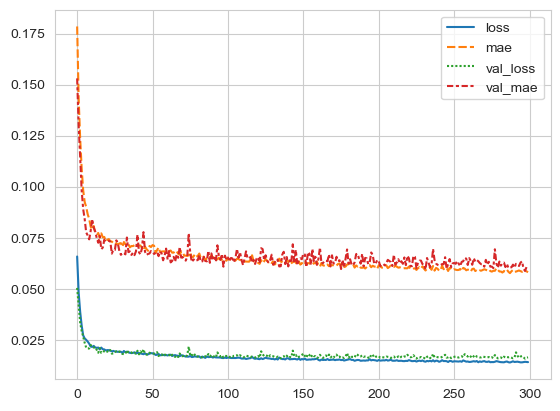

In [20]:
sns.lineplot(history_model_3.history)